## Importación de pyspark 

In [1]:
import pyspark

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import col,round
from pyspark.sql.types import IntegerType, DoubleType, StringType

spark = SparkSession.builder.appName("pruebaTitanic").getOrCreate()
sqlContext = SQLContext(spark)

23/07/25 18:07:47 WARN Utils: Your hostname, alexis-HP-240-G6-Notebook-PC resolves to a loopback address: 127.0.1.1; using 192.168.1.25 instead (on interface wlo1)
23/07/25 18:07:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/25 18:07:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/alexis/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Ubicamos el set de datos para tratar

In [2]:
!ls data/

agentes_inmobiliarios.txt  dim_estado_personas	 operaciones_master.csv
catalogos.xlsx		   dim_residencias	 pasajeros_titanic.csv
clases.csv		   fact_pasajeros	 personas_titanic.csv
dim_clase_viaje		   operaciones_2022.csv  registro_publico.csv
dim_embarque		   operaciones_2023.csv


## Generamos las variables globales para armar el dataframe

In [3]:
pathNotebook = '/home/alexis/Escritorio/alexis/analisisTitanic/data/'
archivo_1 = 'pasajeros_titanic.csv'

## Lo leemos y guardamos en la variable general en donde se ramificara el analisis

In [4]:
pasajeros_titanic = spark.read.csv(pathNotebook+archivo_1, header="true", sep=",")

## Identificamos la estructura del dataframe para ver como lo infirió Spark

In [5]:
display(pasajeros_titanic)

DataFrame[clase_viaje: string, sobrevivencia: string, nombre: string, sexo: string, edad: string, parientes: string, familiares: string, boleto: string, tarifa: string, cabina: string, embarque: string, bote: string, cuerpo: string, residencias: string]

## Casteo de datos para el analisis y visualización del nuevo schema que formamos

In [6]:
pasajeros_titanic = pasajeros_titanic.withColumn("clase_viaje", col("clase_viaje").cast(IntegerType()))
pasajeros_titanic = pasajeros_titanic.withColumn("sobrevivencia", col("sobrevivencia").cast(IntegerType()))
pasajeros_titanic = pasajeros_titanic.withColumn("edad", col("edad").cast(IntegerType()))
pasajeros_titanic = pasajeros_titanic.withColumn("parientes", col("parientes").cast(IntegerType()))
pasajeros_titanic = pasajeros_titanic.withColumn("familiares", col("familiares").cast(IntegerType()))
pasajeros_titanic = pasajeros_titanic.withColumn("tarifa", round(col("tarifa").cast(DoubleType()),2))
pasajeros_titanic.printSchema()

root
 |-- clase_viaje: integer (nullable = true)
 |-- sobrevivencia: integer (nullable = true)
 |-- nombre: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- parientes: integer (nullable = true)
 |-- familiares: integer (nullable = true)
 |-- boleto: string (nullable = true)
 |-- tarifa: double (nullable = true)
 |-- cabina: string (nullable = true)
 |-- embarque: string (nullable = true)
 |-- bote: string (nullable = true)
 |-- cuerpo: string (nullable = true)
 |-- residencias: string (nullable = true)



## Renombramiento de columnas

In [7]:
pasajeros_titanic = pasajeros_titanic.withColumnRenamed('sobrevivencia', 'estado_id')
pasajeros_titanic = pasajeros_titanic.withColumnRenamed('clase_viaje', 'viaje_id')
pasajeros_titanic = pasajeros_titanic.withColumnRenamed('embarque', 'embarque_id')
pasajeros_titanic.printSchema()

root
 |-- viaje_id: integer (nullable = true)
 |-- estado_id: integer (nullable = true)
 |-- nombre: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- parientes: integer (nullable = true)
 |-- familiares: integer (nullable = true)
 |-- boleto: string (nullable = true)
 |-- tarifa: double (nullable = true)
 |-- cabina: string (nullable = true)
 |-- embarque_id: string (nullable = true)
 |-- bote: string (nullable = true)
 |-- cuerpo: string (nullable = true)
 |-- residencias: string (nullable = true)



## Quitamos las "" de los nombres

In [8]:
UDF_replace_coma = F.udf(lambda s: s.replace('"',"").replace('""',"") if s is not None else None, StringType())
pasajeros_titanic = pasajeros_titanic.withColumn('nombre', UDF_replace_coma('nombre'))

In [9]:
pasajeros_titanic.select('nombre').show(10,truncate=False)

+----------------------------------------------------+
|nombre                                              |
+----------------------------------------------------+
|Andrews, Mr. Thomas Jr                              |
|Chisholm, Mr. Roderick Robert Crispin               |
|Fry, Mr. Richard                                    |
|Harrison, Mr. William                               |
|Ismay, Mr. Joseph Bruce                             |
|Parr, Mr. William Henry Marsh                       |
|Reuchlin, Jonkheer. John George                     |
|Carlsson, Mr. Frans Olof                            |
|Colley, Mr. Edward Pomeroy                          |
|Cornell, Mrs. Robert Clifford (Malvina Helen Lamson)|
+----------------------------------------------------+
only showing top 10 rows



## Dimensionamos
A partir de como está conformado el schema del DataFrame decidí generar otras dimensiones y establecer una unica tabla de facts para tener de esta forma un modelo estrella

## Creación de la dimensión embarque y guardado de archivo

In [10]:
embarque_count = pasajeros_titanic.groupBy('embarque_id').count()
embarque = embarque_count
embarque_table = embarque.createOrReplaceTempView('embarque')
new_embarque_table = spark.sql('SELECT CASE WHEN embarque_id = "C" THEN "1" WHEN embarque_id = "S" THEN "2" WHEN embarque_id = "Q" THEN "3" ELSE "null" END AS embarque_id, embarque_id as embarque FROM embarque')
new_embarque_table.write.csv(pathNotebook+'dim_embarque',header=True)


## Renombramiento de la dimensión EMBARQUE y actualización de datos

In [11]:
UDF_python = F.udf(lambda s: s.replace("C", "1").replace("S","2").replace("Q","3") if s is not None else None, StringType())
pasajeros_titanic = pasajeros_titanic.withColumn("embarque_id", UDF_python("embarque_id"))
pasajeros_titanic = pasajeros_titanic.withColumn("embarque_id", col("embarque_id").cast(IntegerType()))

## Creación de la dimensión clase_viaje y guardado de archivo

In [12]:
clase_viaje_count = pasajeros_titanic.groupBy('viaje_id').count()
clase_viaje = clase_viaje_count
clase_viaje_table = clase_viaje.createOrReplaceTempView('clase_viaje')
new_clase_viaje = spark.sql("""SELECT viaje_id , case when viaje_id = 1 then "PRIMERA CLASE"  
                                    when viaje_id = 2 then "SEGUNDA CLASE"
                                    when viaje_id = 3 then "TERCERA CLASE"
                                    else "NA" end as tipo_clase_viaje
                                FROM clase_viaje""")
new_clase_viaje.write.csv(pathNotebook+'dim_clase_viaje',header=True)

## Creación de la dimensión estado_persona y guardado de archivo

In [13]:
sobrevivencia = pasajeros_titanic.groupBy('estado_id').count()
sobrevivencia_table = sobrevivencia.createOrReplaceTempView('sobrevivencia')
new_sobrevivencia_table = spark.sql("""SELECT estado_id , CASE WHEN estado_id = 0 THEN "Murió" 
                WHEN estado_id = 1 THEN "Sobrevivió"
                ELSE "No encontrado" END AS estado_persona
            FROM sobrevivencia""")

new_sobrevivencia_table.show()
new_sobrevivencia_table.write.csv(pathNotebook+'dim_estado_personas', header=True)

+---------+--------------+
|estado_id|estado_persona|
+---------+--------------+
|     null| No encontrado|
|        1|    Sobrevivió|
|        0|         Murió|
+---------+--------------+



## Cantidad de residencias en el DataFrame

In [14]:
cant_residencias = pasajeros_titanic.select('residencias').distinct()
cant_residencias = cant_residencias.sort(cant_residencias['residencias'].asc()).select('residencias')
cant_residencias.write.csv(pathNotebook+'dim_residencias',header=True)
cant_residencias.show(371,truncate=False)

+--------------------------------------------------+
|residencias                                       |
+--------------------------------------------------+
|null                                              |
|?Havana, Cuba                                     |
|Aberdeen / Portland, OR                           |
|Albany, NY                                        |
|Altdorf, Switzerland                              |
|Amenia, ND                                        |
|Antwerp, Belgium / Stanton, OH                    |
|Argentina                                         |
|Asarum, Sweden Brooklyn, NY                       |
|Ascot, Berkshire / Rochester, NY                  |
|Auburn, NY                                        |
|Aughnacliff, Co Longford, Ireland New York, NY    |
|Australia Fingal, ND                              |
|Austria                                           |
|Austria Niagara Falls, NY                         |
|Austria-Hungary                              

## Creación de la fact Pasajeros

In [15]:
new_pasajeros_titanic = pasajeros_titanic
new_pasajeros_titanic = new_pasajeros_titanic.createOrReplaceTempView('new_pasajeros')
new_pasajeros_titanic_table = spark.sql("""
    SELECT * FROM new_pasajeros
""")

new_pasajeros_titanic_table.write.csv(pathNotebook+'fact_pasajeros', header=True)

# Modelo Final

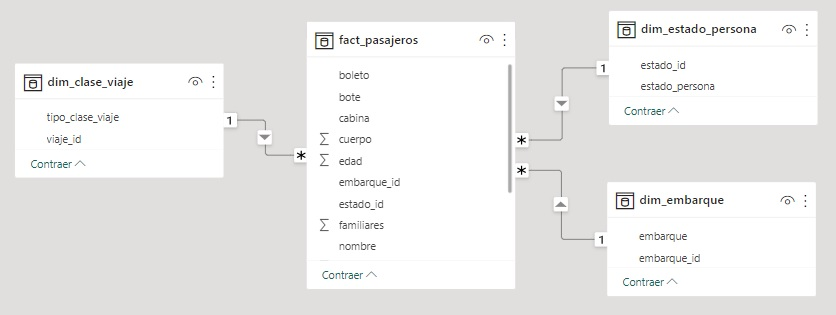

In [18]:
from IPython.display import Image
Image(filename='./images/modeloAnaliticaTitanic.jpg')

# Análisis del set mediante JOINS
Generamos uniones de dimensiones con la fact para analisar los datos

### Cantidad de pasajeros que muerieron menores de 20 años

In [16]:
pasajeros_estado_join = pasajeros_titanic.select('nombre','sexo','edad','estado_id','residencias') \
    .join(new_sobrevivencia_table, pasajeros_titanic['estado_id'] == new_sobrevivencia_table['estado_id'],"left" ) \

pasajeros_estado_muertos = pasajeros_estado_join.filter(pasajeros_estado_join['estado_persona'] == 'Murió')
pasajeros_estado_muertos = pasajeros_estado_muertos.filter(pasajeros_estado_muertos['edad'] < 20).groupBy('edad').count()
cant_pasaj_muertos_menores_20 = pasajeros_estado_muertos.sort(col('count').desc())
cant_pasaj_muertos_menores_20.show()

+----+-----+
|edad|count|
+----+-----+
|  18|   28|
|  19|   18|
|  17|   13|
|  16|   11|
|   2|    8|
|   9|    6|
|  14|    6|
|  10|    4|
|  11|    4|
|   1|    3|
|   6|    3|
|   4|    3|
|  13|    2|
|   3|    2|
|   8|    2|
|   7|    2|
|   0|    2|
|   5|    1|
|  15|    1|
+----+-----+



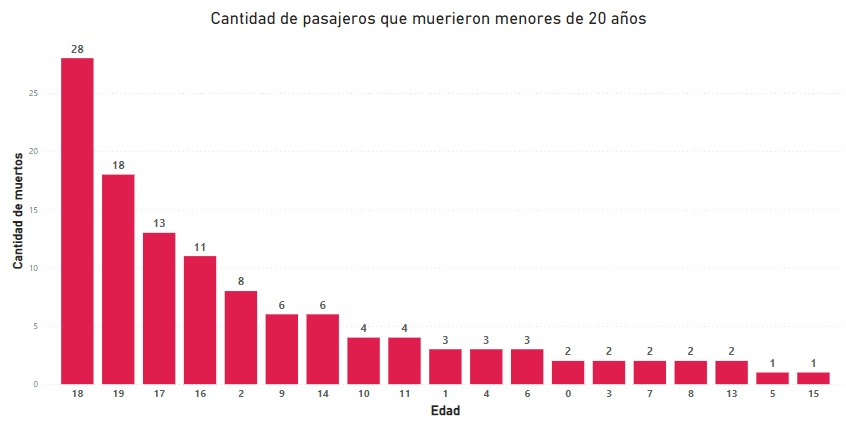

In [19]:
Image(filename='./images/pasajeros_muertos_menores_20.jpg')

### Cantidad de pasajeros que muerieron agrupados por sexo

In [20]:
pasajeros_sexo_edad = pasajeros_titanic \
    .join(new_sobrevivencia_table, pasajeros_titanic['estado_id'] == new_sobrevivencia_table['estado_id'],"left")
pasaj_sex_edad_muertos = pasajeros_sexo_edad.filter(pasajeros_sexo_edad['estado_persona'] == 'Murió').select('sexo','edad','estado_persona')
pasaj_sex_edad_muertos = pasaj_sex_edad_muertos.groupBy('sexo').count()
pasaj_sex_edad_muertos.show()

+------+-----+
|  sexo|count|
+------+-----+
|hombre|  679|
| mujer|  127|
|  null|    1|
+------+-----+



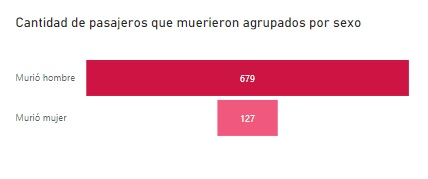

In [21]:
Image(filename='./images/pasajeros_murieron_agrupados_sexo.jpg')

### Cantidad de pasajeros que sobrevivieron agrupados por sexo

In [22]:
pasajeros_sexo_edad = pasajeros_titanic \
    .join(new_sobrevivencia_table, pasajeros_titanic['estado_id'] == new_sobrevivencia_table['estado_id'],"left")
pasaj_sex_edad_sobrev = pasajeros_sexo_edad.filter(pasajeros_sexo_edad['estado_persona'] == 'Sobrevivió').select('sexo','edad','estado_persona')
pasaj_sex_edad_sobrev = pasaj_sex_edad_sobrev.groupBy('sexo').count()
pasaj_sex_edad_sobrev.show()

+------+-----+
|  sexo|count|
+------+-----+
|hombre|  160|
| mujer|  338|
|  null|    2|
+------+-----+



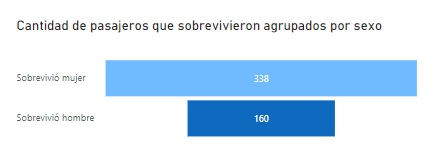

In [23]:
Image(filename='./images/pasajeros_sobrevivieron_agrupados_sexo.jpg')

### Cantidad de pasajeros que murieron por clase

In [24]:
pasaj_por_clase = pasajeros_titanic.join(new_clase_viaje, pasajeros_titanic['viaje_id'] == new_clase_viaje['viaje_id'],'left') \
    .join(new_sobrevivencia_table, pasajeros_titanic['estado_id'] == new_sobrevivencia_table['estado_id'],"left") \
    .select('nombre','sexo','edad','tipo_clase_viaje','estado_persona')

pasaj_por_clase_muertos = pasaj_por_clase.filter(pasaj_por_clase['estado_persona'] == 'Murió')
pasaj_primera_muertos = pasaj_por_clase_muertos.filter(pasaj_por_clase_muertos['tipo_clase_viaje'] == 'PRIMERA CLASE')
pasaj_segunda_muertos = pasaj_por_clase_muertos.filter(pasaj_por_clase_muertos['tipo_clase_viaje'] == 'SEGUNDA CLASE')
pasaj_tercera_muertos = pasaj_por_clase_muertos.filter(pasaj_por_clase_muertos['tipo_clase_viaje'] == 'TERCERA CLASE')

In [25]:
pasaj_primera_muertos.count()

118

In [26]:
pasaj_segunda_muertos.count()

158

In [27]:
pasaj_tercera_muertos.count()

529

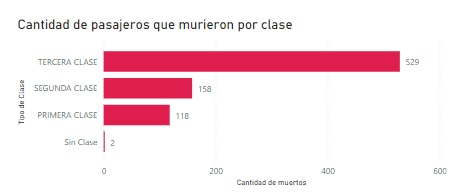

In [28]:
Image(filename='./images/pasajeros_murieron_agrupados_clase.jpg')

### Cantidad de pasajeros que murieron por clase que fueron hombres

In [29]:
cuent = pasaj_por_clase_muertos.filter(pasaj_por_clase_muertos['sexo'] == 'hombre')
cuent = cuent.groupBy('tipo_clase_viaje').count()
final_cuent_hombres = cuent.sort(cuent['count'].desc())
final_cuent_hombres.show()

+----------------+-----+
|tipo_clase_viaje|count|
+----------------+-----+
|   TERCERA CLASE|  419|
|   SEGUNDA CLASE|  146|
|   PRIMERA CLASE|  112|
|            null|    2|
+----------------+-----+



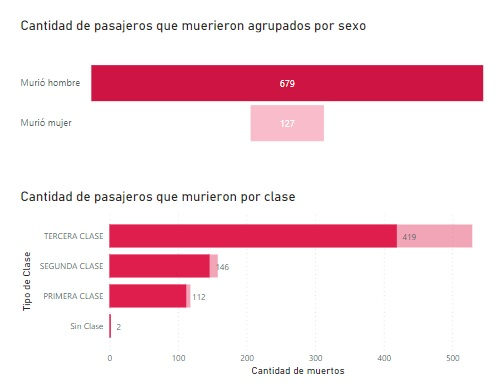

In [30]:
Image(filename='./images/pasajeros_murieron_xClase_hombres.jpg')

### Cantidad de pasajeros que murieron por clase que fueron mujer

In [31]:
cuent = pasaj_por_clase_muertos.filter(pasaj_por_clase_muertos['sexo'] == 'mujer')
cuent = cuent.groupBy('tipo_clase_viaje').count()
final_cuent_mujeres = cuent.sort(cuent['count'].desc())
final_cuent_mujeres.show()

+----------------+-----+
|tipo_clase_viaje|count|
+----------------+-----+
|   TERCERA CLASE|  110|
|   SEGUNDA CLASE|   12|
|   PRIMERA CLASE|    5|
+----------------+-----+



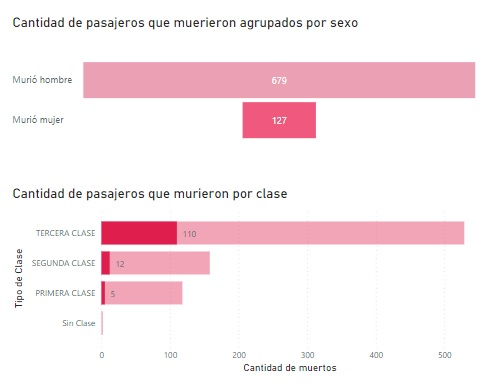

In [32]:
Image(filename='./images/pasajeros_murieron_xClase_mujeres.jpg')

In [33]:
spark.stop()